# Test model to check OC module

In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import config
import flopy


workspace = './lake'
# make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

fext = 'png'
narg = len(sys.argv)
iarg = 0
if narg > 1:
    while iarg < narg - 1:
        iarg += 1
        basearg = sys.argv[iarg].lower()
        if basearg == '--pdf':
            fext = 'pdf'

# We are creating a square model with a specified head equal to `h1` along all boundaries.
# The head at the cell in the center in the top layer is fixed to `h2`. First, set the name
# of the model and the parameters of the model: the number of layers `Nlay`, the number of rows
# and columns `N`, lengths of the sides of the model `L`, aquifer thickness `H`, hydraulic
# conductivity `Kh`
name = 'lake_example'
h1 = 100
h2 = 90
Nlay = 10
N = 101
L = 400.0
H = 50.0
Kh = 1.0

# Create a MODFLOW model and store it (in this case in the variable `ml`, but you can call it
# whatever you want). The modelname will be the name given to all MODFLOW files (input and output).
# The exe_name should be the full path to your MODFLOW executable. The version is either 'mf2k'
# for MODFLOW2000 or 'mf2005'for MODFLOW2005.
ml = flopy.modflow.Modflow(modelname=name,  version='mf2k',model_ws=workspace)
ml.exe_name = config.mf2000exe
# Define the discretization of the model. All layers are given equal thickness. The `bot` array
# is build from the `Hlay` values to indicate top and bottom of each layer, and `delrow` and
# `delcol` are computed from model size `L` and number of cells `N`. Once these are all computed,
# the Discretization file is built.
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.modflow.ModflowDis(ml, nlay=Nlay, nrow=N, ncol=N, delr=delrow,
                               delc=delcol, top=0.0, botm=bot, laycbd=0)

# Next we specify the boundary conditions and starting heads with the Basic package. The `ibound`
# array will be `1` in all cells in all layers, except for along the boundary and in the cell at
# the center in the top layer where it is set to `-1` to indicate fixed heads. The starting heads
# are used to define the heads in the fixed head cells (this is a steady simulation, so none of
# the other starting values matter). So we set the starting heads to `h1` everywhere, except for
# the head at the center of the model in the top layer.
Nhalf = int((N - 1) / 2)
ibound = np.ones((Nlay, N, N), dtype=np.int)
ibound[:, 0, :] = -1
ibound[:, -1, :] = -1
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
ibound[0, Nhalf, Nhalf] = -1

start = h1 * np.ones((N, N))
start[Nhalf, Nhalf] = h2

# create external ibound array and starting head files
files = []
hfile = '{}_strt.ref'.format(name)
np.savetxt(hfile, start)
hfiles = []
for kdx in range(Nlay):
    file = '{}_ib{:02d}.ref'.format(name, kdx + 1)
    files.append(file)
    hfiles.append(hfile)
    np.savetxt(file, ibound[kdx, :, :], fmt='%5d')

bas = flopy.modflow.ModflowBas(ml, ibound=files, strt=hfiles)

# The aquifer properties (really only the hydraulic conductivity) are defined with the
# LPF package.
lpf = flopy.modflow.ModflowLpf(ml, hk=Kh)

# Finally, we need to specify the solver we want to use (PCG with default values), and the
# output control (using the default values). Then we are ready to write all MODFLOW input
# files and run MODFLOW.
pcg = flopy.modflow.ModflowPcg(ml)
oc = flopy.modflow.ModflowOc(ml)
ml.write_input()


FloPy is using the following  executable to run the model: /usr/local/bin/MODFLOW/mf2000

                                  MODFLOW-2000
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.19.01 03/25/2010                      

 Using NAME file: lake_example.nam                                                                                                                                                                                        
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/15  9:26:17

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/15  9:26:17
 Elapsed run time:  0.502 Seconds

 Normal termination of MODFLOW-2000
created... ./lake/lake1.png
created... ./lake/lake2.png
created... ./lake/lake3.png


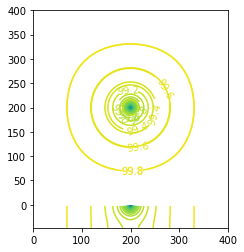

In [6]:
ml.run_model()


# # change back to the starting directory
# os.chdir(cwdpth)

# Once the model has terminated normally, we can read the heads file. First, a link to the heads
# file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by
# specifying, in this case, the step number and period number for which we want to retrieve data.
# A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions
# are used to make contours of the layers or a cross-section.
hds = flopy.utils.HeadFile(os.path.join(workspace, name + '.hds'))
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
c = plt.contour(x, y, h[0], np.arange(90, 100.1, 0.2))
plt.clabel(c, fmt='%2.1f')
plt.axis('scaled')

outfig = os.path.join(workspace, 'lake1.{0}'.format(fext))
fig = plt.gcf()
fig.savefig(outfig, dpi=300)
print('created...', outfig)

x = y = np.linspace(0, L, N)
c = plt.contour(x, y, h[-1], np.arange(90, 100.1, 0.2))
plt.clabel(c, fmt='%1.1f')
plt.axis('scaled')

outfig = os.path.join(workspace, 'lake2.{0}'.format(fext))
fig = plt.gcf()
fig.savefig(outfig, dpi=300)
print('created...', outfig)

z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)
c = plt.contour(x, z, h[:, 50, :], np.arange(90, 100.1, .2))
plt.axis('scaled')

outfig = os.path.join(workspace, 'lake3.{0}'.format(fext))
fig = plt.gcf()
fig.savefig(outfig, dpi=300)
print('created...', outfig)
